# Vanishing Gradients in RNN Seq2Seq Models

This notebook analyzes the vanishing gradient problem in vanilla RNN models for neural machine translation.

## What are Vanishing Gradients?

Vanishing gradients occur when gradients become exponentially small as they backpropagate through time in recurrent networks. For vanilla RNNs:

$$h_t = \tanh(W_{ih}x_t + W_{hh}h_{t-1} + b)$$

The gradient of $\tanh$ is bounded: $|\tanh'(x)| \leq 1$, and when backpropagating through $T$ timesteps, gradients are multiplied by $W_{hh}$ repeatedly:

$$\frac{\partial L}{\partial h_0} = \frac{\partial L}{\partial h_T} \prod_{t=1}^{T} \frac{\partial h_t}{\partial h_{t-1}}$$

If the largest eigenvalue of $W_{hh}$ is < 1, gradients vanish exponentially with sequence length.

## Impact on Seq2Seq Translation

In encoder-decoder models:
- **Encoder**: Processes long source sequences → gradients must flow back through entire sequence
- **Decoder**: Processes shorter target sequences step-by-step → less affected

This asymmetry means the encoder stops learning while the decoder continues, leading to:
- Encoder producing uninformative context vectors
- Decoder learning target language patterns but ignoring source content
- Model outputting generic/repetitive text regardless of input

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent))

# Matplotlib styling
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

In [ ]:
# Load training history from RNN training
history_path = Path('../models/checkpoints/rnn_history.csv')
df = pd.read_csv(history_path)

print("Training History:")
print(df.to_string(index=False))
print(f"\nTotal epochs: {len(df)}")

## Visualize Gradient Evolution

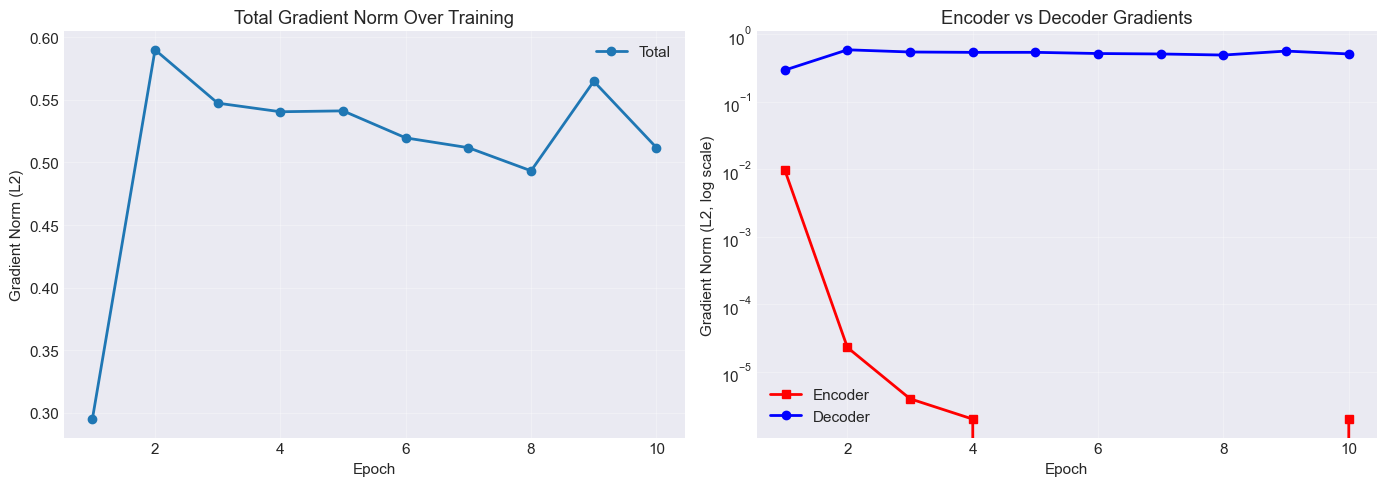

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Total gradient norm over epochs
axes[0].plot(df['epoch'], df['grad_norm_total'], marker='o', linewidth=2, label='Total')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Gradient Norm (L2)')
axes[0].set_title('Total Gradient Norm Over Training')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: Encoder vs Decoder gradients (log scale)
axes[1].plot(df['epoch'], df['grad_norm_encoder'], marker='s', linewidth=2, label='Encoder', color='red')
axes[1].plot(df['epoch'], df['grad_norm_decoder'], marker='o', linewidth=2, label='Decoder', color='blue')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Gradient Norm (L2, log scale)')
axes[1].set_title('Encoder vs Decoder Gradients')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

## Layer-wise Gradient Analysis

In [26]:
from src.models.rnn_seq2seq import RNNSeq2Seq
from src.data.bpe_tokenizer import BPETokenizer
from src.data.dataset import TranslationDataset
import torch.nn as nn
from torch.utils.data import DataLoader
from src.data.dataset import collate_fn

# Setup device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# Load tokenizer
tokenizer = BPETokenizer.load('../data/vocab/bpe_vocab_shared.pkl')
vocab_size = len(tokenizer.token2idx)
pad_idx = tokenizer.token2idx[tokenizer.PAD_TOKEN]

# Load model
checkpoint = torch.load('../models/checkpoints/rnn_best.pt', map_location=device, weights_only=False)
model_config = checkpoint['model_config']

model = RNNSeq2Seq(
    vocab_size=vocab_size,
    embedding_dim=model_config['embedding_dim'],
    hidden_dim=model_config['hidden_dim'],
    num_layers=model_config['num_layers'],
    dropout=model_config['dropout'],
    pad_idx=pad_idx,
)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.train()  # Need gradients

print(f"Model loaded (trained for {checkpoint['epoch']+1} epochs)")

# Load a sample batch
dataset = TranslationDataset(
    '../data/processed/opus-100/train.en',
    '../data/processed/opus-100/train.es',
    tokenizer,
    max_len=100
)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, 
                        collate_fn=lambda batch: collate_fn(batch, pad_idx))
src, src_lengths, tgt, tgt_lengths = next(iter(dataloader))

src = src.to(device)
tgt = tgt.to(device)
src_lengths = src_lengths.to(device)

print(f"Batch loaded: src={src.shape}, tgt={tgt.shape}")

Using device: mps
Model loaded (trained for 5 epochs)
Batch loaded: src=torch.Size([32, 100]), tgt=torch.Size([32, 100])


In [27]:
# Forward and backward pass
model.zero_grad()

# Forward
tgt_input = tgt[:, :-1]
tgt_output = tgt[:, 1:]

logits = model(src, tgt_input, src_lengths)

# Compute loss
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
logits_flat = logits.reshape(-1, logits.size(-1))
tgt_flat = tgt_output.reshape(-1)
loss = criterion(logits_flat, tgt_flat)

# Backward
loss.backward()

print(f"Loss: {loss.item():.4f}")

Loss: 3.4730


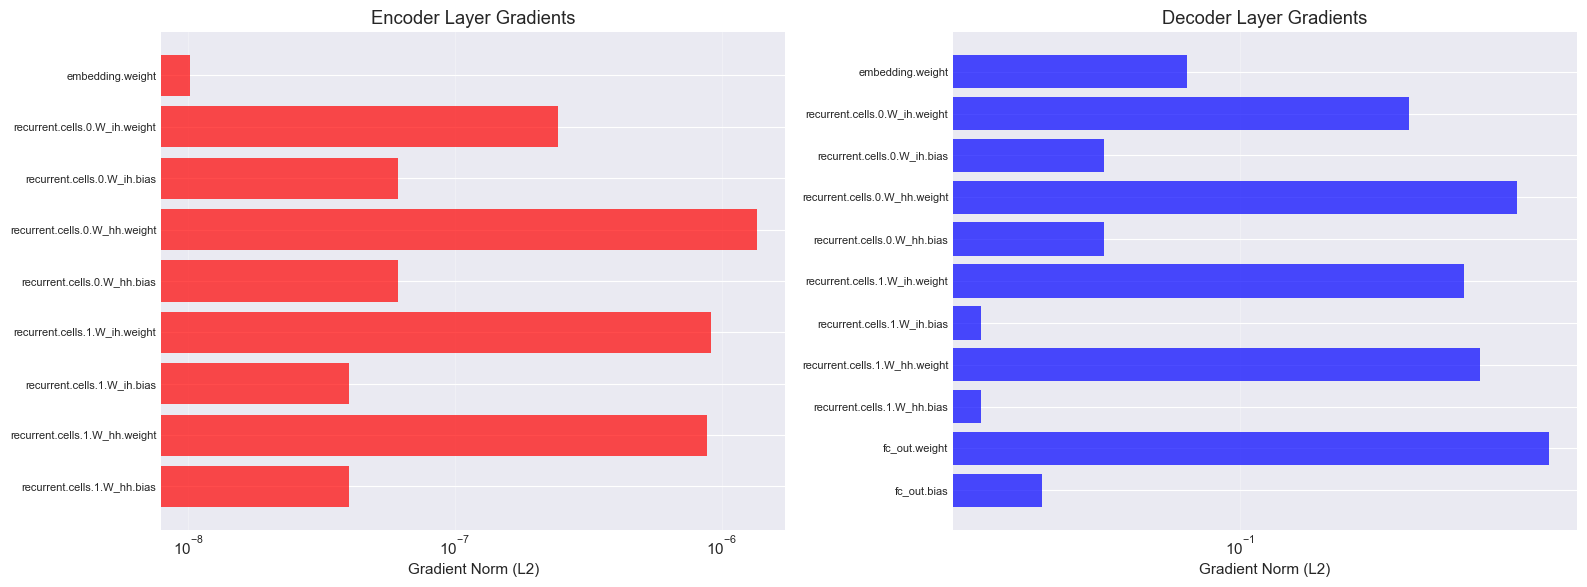


Total encoder gradient norm: 0.000004
Total decoder gradient norm: 2.553341
Ratio (encoder/decoder): 0.000001


In [28]:
# Analyze layer-wise gradients
layer_grads = {}

for name, param in model.named_parameters():
    if param.grad is not None:
        layer_grads[name] = param.grad.norm(2).item()

# Group by component
encoder_layers = {k: v for k, v in layer_grads.items() if 'encoder' in k}
decoder_layers = {k: v for k, v in layer_grads.items() if 'decoder' in k}

# Prepare data for visualization
encoder_names = [k.replace('encoder.', '') for k in encoder_layers.keys()]
encoder_vals = list(encoder_layers.values())
decoder_names = [k.replace('decoder.', '') for k in decoder_layers.keys()]
decoder_vals = list(decoder_layers.values())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Encoder gradients
axes[0].barh(range(len(encoder_names)), encoder_vals, color='red', alpha=0.7)
axes[0].set_yticks(range(len(encoder_names)))
axes[0].set_yticklabels(encoder_names, fontsize=8)
axes[0].set_xlabel('Gradient Norm (L2)')
axes[0].set_title('Encoder Layer Gradients')
axes[0].set_xscale('log')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Decoder gradients
axes[1].barh(range(len(decoder_names)), decoder_vals, color='blue', alpha=0.7)
axes[1].set_yticks(range(len(decoder_names)))
axes[1].set_yticklabels(decoder_names, fontsize=8)
axes[1].set_xlabel('Gradient Norm (L2)')
axes[1].set_title('Decoder Layer Gradients')
axes[1].set_xscale('log')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Summary statistics
encoder_total = sum(encoder_layers.values())
decoder_total = sum(decoder_layers.values())
print(f"\nTotal encoder gradient norm: {encoder_total:.6f}")
print(f"Total decoder gradient norm: {decoder_total:.6f}")
print(f"Ratio (encoder/decoder): {encoder_total/decoder_total:.6f}")